STRATEGY 3 : MOMENTUM BASED

HERE IS THE CODE FOR NIFTY 50 FOR HOURLY TIME FRAME

In [53]:
import pandas as pd
from stocktrends import Renko
import numpy as np

In [54]:
# lOAD AND PREPARE DATA

data = pd.read_csv('datasets/NIFTY 50_60min_FINAL.csv', usecols=[0,1,2,3,4,5,6])
data['date'] = data['date'].str.split(' ').str[0]
df = data.sort_index(ascending=False)
n_df = data.copy()
n_df = n_df.sort_index(ascending=False)
adj_close = n_df.iloc[-1]['close']
df.head()

,date,time,open,high,low,close,volume
8854,2025-02-07,15:15:00,23574.00,23591.25,23557.35,23563.15,0
8853,2025-02-07,14:15:00,23460.95,23574.75,23443.20,23573.70,0
8852,2025-02-07,13:15:00,23547.85,23591.40,23453.25,23461.05,0
8851,2025-02-07,12:15:00,23572.35,23610.55,23537.65,23547.70,0
8850,2025-02-07,11:15:00,23616.25,23694.50,23572.80,23573.90,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8855 entries, 8854 to 0
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8855 non-null   object 
 1   time    8855 non-null   object 
 2   open    8855 non-null   float64
 3   high    8855 non-null   float64
 4   low     8855 non-null   float64
 5   close   8855 non-null   float64
 6   volume  8855 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 553.4+ KB


BUILDING RENKO BRICKS

In [56]:
# CONVERTING DATA TO RENKO CHART
def df_to_renko(data, n):
    data.reset_index(inplace=True)
    data.columns = [i.lower() for i in data.columns]
    df = Renko(data)
    df.brick_size = n
    renko_df = df.get_ohlc_data()
    return renko_df

size = 20
renko_df = df_to_renko(df, size)

In [57]:
# USING INDICATORS FOR RENKO
renko_df['sma_5'] = renko_df['close'].rolling(window=5).mean()
renko_df['H-L'] = renko_df['high'] - renko_df['low']
renko_df['H-PC'] = abs(renko_df['high'] - renko_df['close'].shift(1))
renko_df['L-PC'] = abs(renko_df['low'] - renko_df['close'].shift(1))
renko_df['TR'] = renko_df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

up_move = renko_df['high'] - renko_df['high'].shift(1)
down_move = renko_df['low'].shift(1) - renko_df['low']
renko_df['+DM'] = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
renko_df['-DM'] = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
renko_df['+DM'] = renko_df['+DM'].astype(float).fillna(0)
renko_df['-DM'] = renko_df['-DM'].astype(float).fillna(0)

tr14 = renko_df['TR'].rolling(window=14).sum()
plus_dm14 = renko_df['+DM'].rolling(window=14).sum()
minus_dm14 = renko_df['-DM'].rolling(window=14).sum()
renko_df['+DI'] = 100 * (plus_dm14 / tr14)
renko_df['-DI'] = 100 * (minus_dm14 / tr14)
renko_df['DX'] = 100 * abs(renko_df['+DI'] - renko_df['-DI']) / (renko_df['+DI'] + renko_df['-DI'])
renko_df['ADX'] = renko_df['DX'].rolling(window=14).mean()
renko_df['adx_diff'] = renko_df['ADX'].diff()


PREPARING OF STRATEGY

In [58]:
# GENERATING SIGNALS

signals = []
position = None
for i in range(1, len(renko_df)):
    row = renko_df.iloc[i]
    long_condition = row['close'] > row['sma_5'] and row['ADX'] > 25 and row['adx_diff'] > 0
    short_condition = row['close'] < row['sma_5'] and row['ADX'] > 25 and row['adx_diff'] > 0

    if long_condition and position != 'long':
        signals.append(('Buy', row['date'], row['close']))
        position = 'long'
    elif short_condition and position != 'short':
        signals.append(('Sell', row['date'], row['close']))
        position = 'short'

In [59]:
# PARAMETERS FOR TRADE

capital = 2500000
leverage = 5
capital *= leverage
tp = 200
sl = 50
slippage_pct = 0.0001  # 0.01%
lot_size = 75

In [60]:
trades = []

for idx, (action, entry_date, entry_price) in enumerate(signals):
    entry_idx = renko_df[renko_df['date'] == entry_date].index[0]
    future_df = renko_df.iloc[entry_idx + 1:]

    # Apply slippage on entry
    entry_price_slipped = entry_price * (1 + slippage_pct) if action == 'Buy' else entry_price * (1 - slippage_pct)

    exit_price = entry_price_slipped
    exit_reason = "None"

    for _, future_row in future_df.iterrows():
        high = future_row['high']
        low = future_row['low']

        if action == 'Buy':
            if high >= entry_price + tp:
                exit_price = (entry_price + tp) * (1 - slippage_pct)
                exit_reason = 'TP'
                break
            elif low <= entry_price - sl:
                exit_price = (entry_price - sl) * (1 - slippage_pct)
                exit_reason = 'SL'
                break
        else:  # Sell
            if low <= entry_price - tp:
                exit_price = (entry_price - tp) * (1 + slippage_pct)
                exit_reason = 'TP'
                break
            elif high >= entry_price + sl:
                exit_price = (entry_price + sl) * (1 + slippage_pct)
                exit_reason = 'SL'
                break

    if exit_reason == "None" and not future_df.empty:
        exit_price = future_df.iloc[-1]['close']
        exit_price = exit_price * (1 - slippage_pct) if action == 'Buy' else exit_price * (1 + slippage_pct)
        exit_reason = 'Forced Exit'

    qty = capital // entry_price_slipped
    pnl = (exit_price - entry_price_slipped) * qty if action == 'Buy' else (entry_price_slipped - exit_price) * qty

    trades.append({
        'type': action,
        'entry_date': entry_date,
        'entry_price': entry_price_slipped,
        'exit_price': exit_price,
        'exit_reason': exit_reason,
        'pnl': pnl,
        'return_pct': pnl / (entry_price_slipped * qty)
    })

trades_df = pd.DataFrame(trades)

FOR DELIVERABLES CODE FOR METRICS

In [61]:
# CALCUTION OF METRICS

total_pnl = trades_df['pnl'].sum()
trades_df['cumulative_return'] = trades_df['pnl'].cumsum()
returns = trades_df['return_pct']


risk_free_rate = 0.06  # 6% annual risk-free rate
annualized_return = returns.mean() * 252
annualized_volatility = returns.std() * np.sqrt(252)
sharpe = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0


# Max Drawdown & Duration 
equity = trades_df['pnl'].cumsum()
roll_max = equity.cummax()
drawdown = roll_max - equity
drawdown_pct = drawdown / roll_max.replace(0, np.nan)

# Track drawdown periods
drawdown_start = None
max_drawdown_duration = 0
current_duration = 0

for i in range(len(drawdown)):
    if drawdown.iloc[i] > 0:
        if drawdown_start is None:
            drawdown_start = trades_df.iloc[i]['entry_date']
        current_duration += 1
        if current_duration > max_drawdown_duration:
            max_drawdown_duration = current_duration
    else:
        drawdown_start = None
        current_duration = 0

max_dd = drawdown.max() if not drawdown.empty else 1


# === Calmar Ratio ===
start_date = pd.to_datetime(trades_df['entry_date']).min()
end_date = pd.to_datetime(trades_df['entry_date']).max()
days = (end_date - start_date).days or 1
total_return_pct = total_pnl / capital
annual_return = total_return_pct * (365 / days)
max_dd_pct = max_dd / capital if capital != 0 else 0
calmar = annual_return / max_dd_pct if max_dd_pct != 0 else 0

# Additional Metrics
num_wins = trades_df[trades_df['pnl'] > 0].shape[0]
num_losses = trades_df[trades_df['pnl'] <= 0].shape[0]
win_rate = num_wins / len(trades_df) if len(trades_df) > 0 else 0
profit_factor = trades_df[trades_df['pnl'] > 0]['pnl'].sum() / abs(trades_df[trades_df['pnl'] <= 0]['pnl'].sum()) if num_losses > 0 else float('inf')

# CAGR Calculation
final_value = capital + total_pnl
cagr = (final_value / capital) ** (365 / days) - 1


In [62]:
# PRINTING THE METRICS
print("Total PnL: ₹{:,}".format(int(total_pnl)))
print("Sharpe Ratio:", round(sharpe, 2))
print("Calmar Ratio:", round(calmar, 2))
print("Max Drawdown: ₹{:,}".format(int(max_dd)))
print("CAGR: {:.2%}".format(cagr))
print("Win Rate: {:.2%}".format(win_rate))
print("Profit Factor:", round(profit_factor, 2))
print("Max Drawdown Duration: {} days".format(max_drawdown_duration))

Total PnL: ₹21,819,591
Sharpe Ratio: 4.89
Calmar Ratio: 6.79
Max Drawdown: ₹630,837
CAGR: 21.92%
Win Rate: 38.33%
Profit Factor: 2.34
Max Drawdown Duration: 30 days


PLOTTING THE CURVES

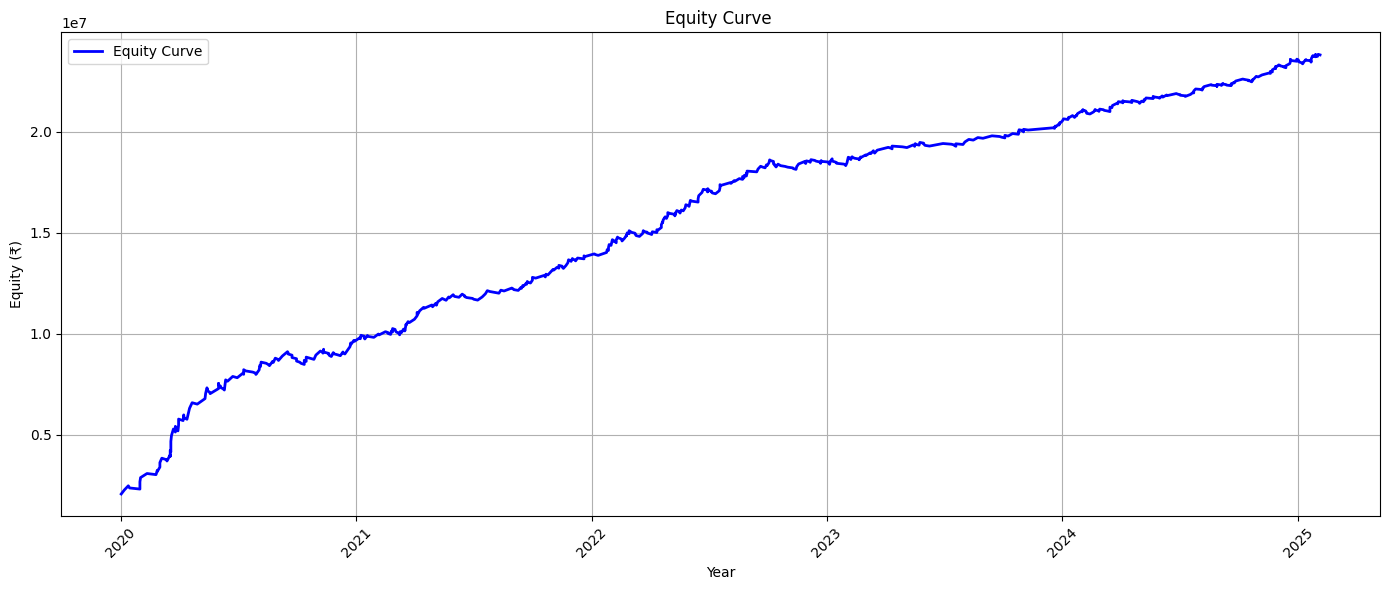

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 7: Equity Curve Calculation and Plot ===

# Sort trades by entry date to maintain correct order
trades_df = trades_df.sort_values(by='entry_date').reset_index(drop=True)

# Initial Capital (with leverage already applied)
initial_capital = 2000000 

# Equity = Initial Capital + Cumulative PnL
trades_df['equity'] = initial_capital + trades_df['pnl'].cumsum()

# Plot Equity Curve
plt.figure(figsize=(14, 6))
plt.plot(trades_df['entry_date'], trades_df['equity'], label='Equity Curve', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Equity (₹)')
plt.title('Equity Curve '.format(initial_capital))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

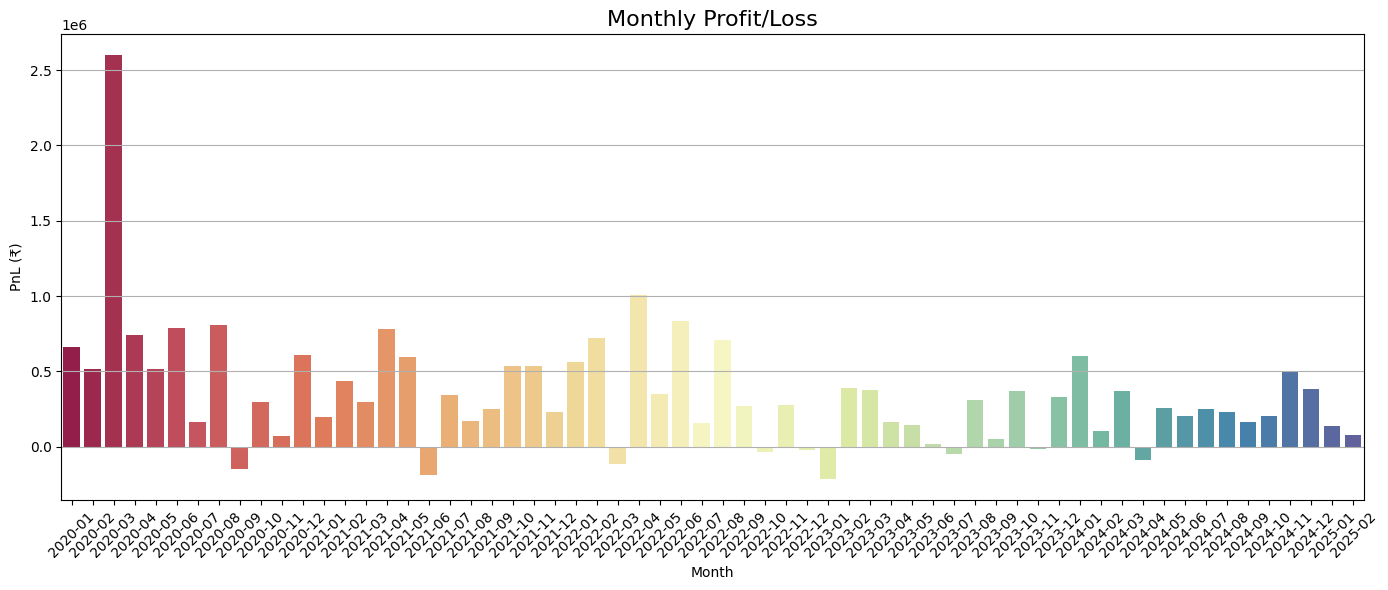

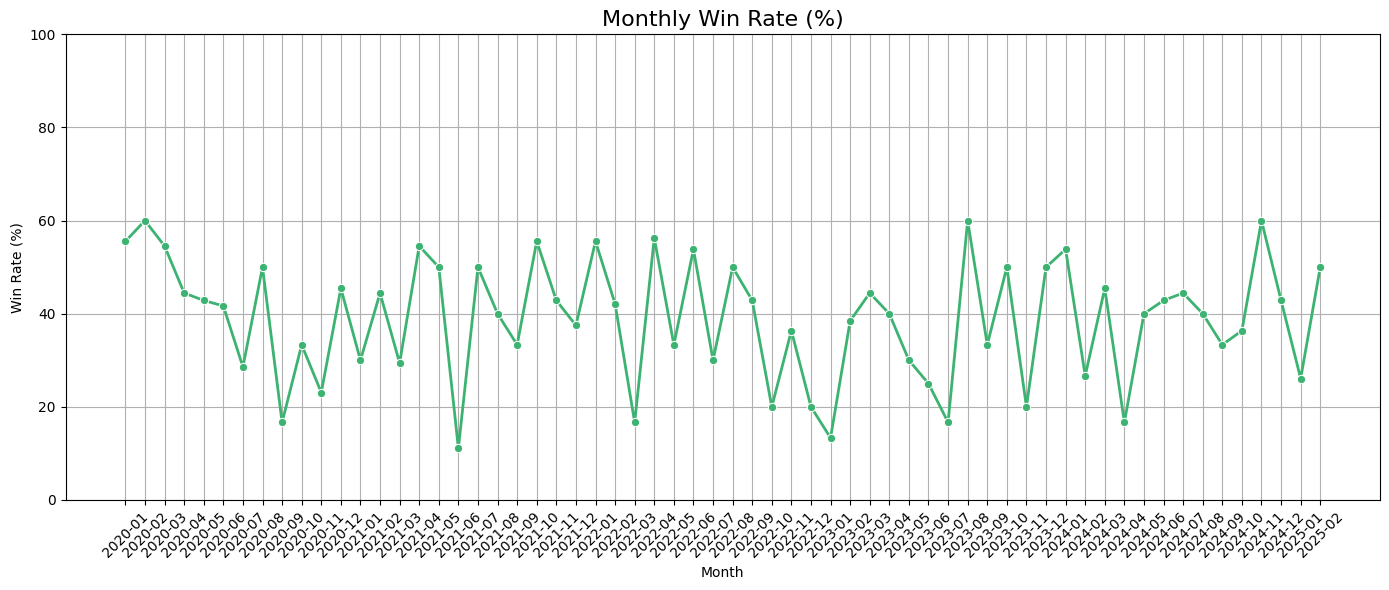

In [64]:
# Ensure entry_date is datetime
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['month'] = trades_df['entry_date'].dt.to_period('M')

# === Monthly PnL Bar Plot ===
monthly_pnl = trades_df.groupby('month')['pnl'].sum()

plt.figure(figsize=(14, 6))
sns.barplot(
    x=monthly_pnl.index.astype(str),
    y=monthly_pnl.values,
    hue=monthly_pnl.index.astype(str),  # Fix for future warning
    palette='Spectral',
    legend=False  # Hide redundant legend
)
plt.xticks(rotation=45)
plt.title('Monthly Profit/Loss', fontsize=16)
plt.xlabel('Month')
plt.ylabel('PnL (₹)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === Monthly Win Rate Plot ===
monthly_stats = trades_df.copy()
monthly_stats['win'] = monthly_stats['pnl'] > 0
monthly_win_rate = monthly_stats.groupby('month')['win'].mean() * 100

plt.figure(figsize=(14, 6))
sns.lineplot(
    x=monthly_win_rate.index.astype(str),
    y=monthly_win_rate.values,
    marker='o',
    color='mediumseagreen',
    linewidth=2
)
plt.xticks(rotation=45)
plt.title('Monthly Win Rate (%)', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()